In [1]:
from flakylib import *
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

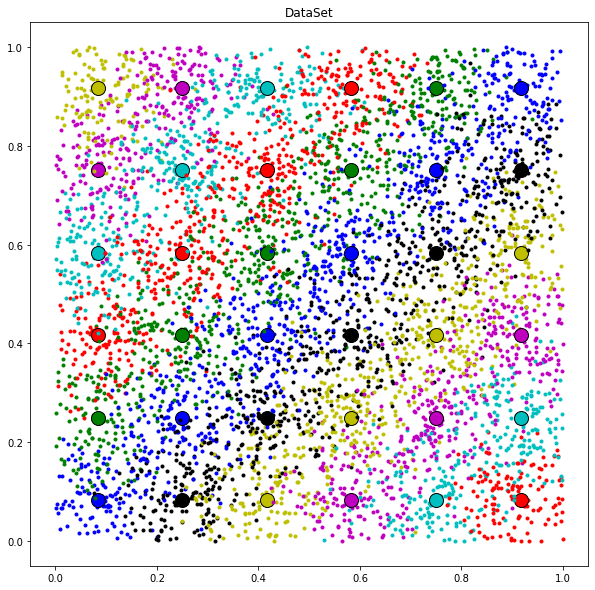

In [2]:
grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

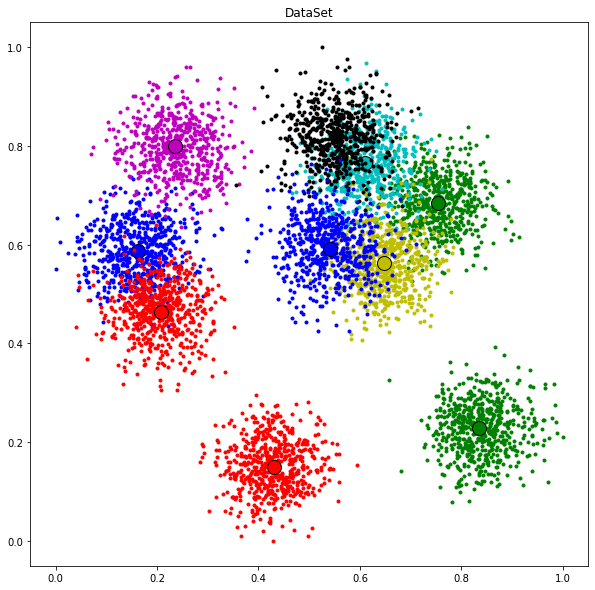

In [6]:
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = gaussian_blobs(n_features, n_samples, n_cluster, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

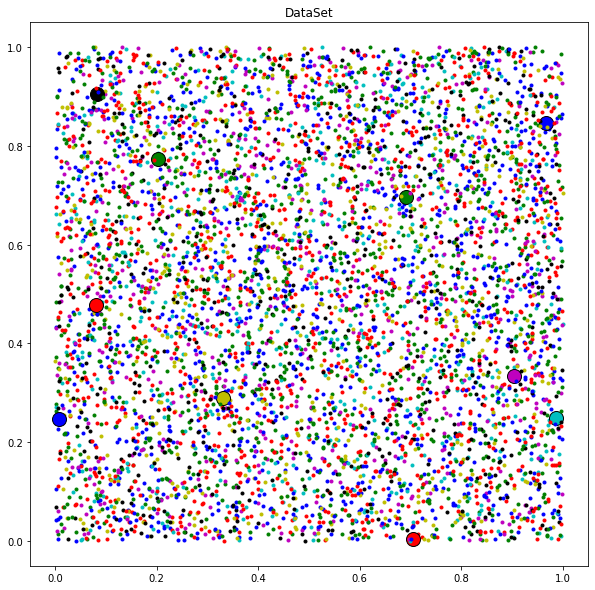

In [4]:
n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [3]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 23.913995123431274

CPU times: user 3.06 s, sys: 8 ms, total: 3.06 s
Wall time: 3.06 s


# Initialization by Random Centroids

In [4]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 59.32707175301347

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.46 ms


# Initialization by K-Means++

In [5]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 33.78354172992871

CPU times: user 24.4 s, sys: 72 ms, total: 24.5 s
Wall time: 24.4 s


# K-Means initialized by True Centroids

In [6]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.072846202345584
Iterations: 26
Clusters: 36

CPU times: user 12.2 s, sys: 12 ms, total: 12.2 s
Wall time: 12.3 s


# K-Means initialized by K-Means++ with sample_objectives as weights

In [8]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.644045419827066
Iterations: 44
Clusters: 36



# K-Means initialized by Random Centroids

In [9]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.16913637776375
Iterations: 69
Clusters: 36

CPU times: user 176 ms, sys: 16 ms, total: 192 ms
Wall time: 39.6 ms


# K-Means initialized by K-Means++

In [10]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.378353386112366
Iterations: 73
Clusters: 36

CPU times: user 248 ms, sys: 36 ms, total: 284 ms
Wall time: 60.9 ms


# K-Means initialized by K-Means++ (sklearn)

In [12]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 23.876480128639855
Iterations: 31
CPU times: user 392 ms, sys: 40 ms, total: 432 ms
Wall time: 117 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [14]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.005842545159293
Iterations: 18
Clusters: 36

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 121 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [16]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.414910873924068
Iterations: 23
Clusters: 36

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 163 ms


# H-Means initialized by Random Membership Distribution

In [18]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.634892177733185
Iterations: 35
Clusters: 36

CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 246 ms


# K-H-Means initialized by True Centroids

In [20]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.00565579317707
Iterations: 45
Clusters: 36

CPU times: user 192 ms, sys: 4 ms, total: 196 ms
Wall time: 143 ms


# K-H-Means initialized by K-Means++

In [22]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.517135112255747
Iterations: 77
Clusters: 36

CPU times: user 360 ms, sys: 4 ms, total: 364 ms
Wall time: 270 ms


# Simple Membership Shaking VNS

In [23]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 300
k_max_iters = 300
h_tol = 0.05
k_tol = 0.0001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.38622640385972
Iterations: 51
Clusters: 36

objective                     k      n_iters        n_iters_k      cpu_time       
23.381828                     1      0              0              0.01           
23.376751                     1      1              0              0.02           
23.346129                     1      2              0              0.03           
23.342079                     1      3              0              0.03           
23.337157                     1      4              0              0.04           
23.325551                     1      5              0              0.05           
23.323216                     1      6              0              0.06           
23.322774                     1      7              0              0.07           
23.321773                     1      8              0              0.07           
23.320836                     1      9              0              0.08           
23.320341                    

# Solution Visualization

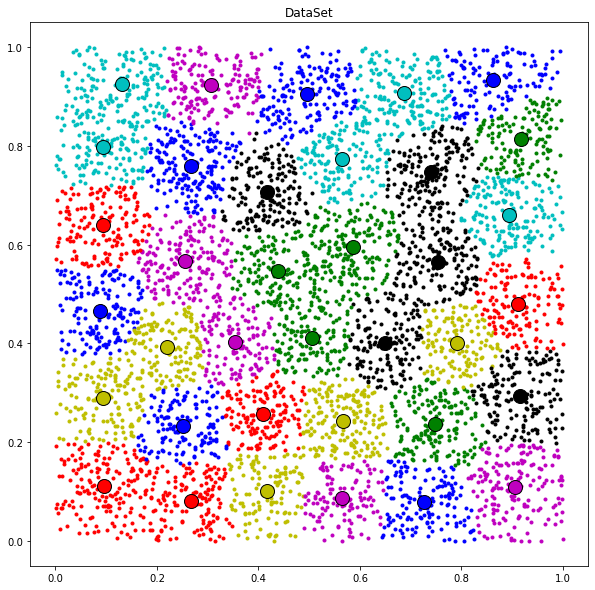

In [24]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [27]:
%%time

# k_max_iters = 50
# k_tol=0.01
k_max_iters = 300
k_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.293633193513813
Iterations: 25
Clusters: 36

objective                     n_iters        cpu_time       
23.199281                     4              0.12           
23.056986                     15             0.36           
23.040274                     31             0.95           
23.028372                     76             2.10           
23.000180                     79             2.17           
22.944029                     152            4.89           
22.944029                     311            10.03          

Objective: 22.944028697138226
Global Iterations: 311
Local Iterations: 25
Clusters: 36

CPU times: user 1min 9s, sys: 9.09 s, total: 1min 19s
Wall time: 10.1 s


# Solution Visualization

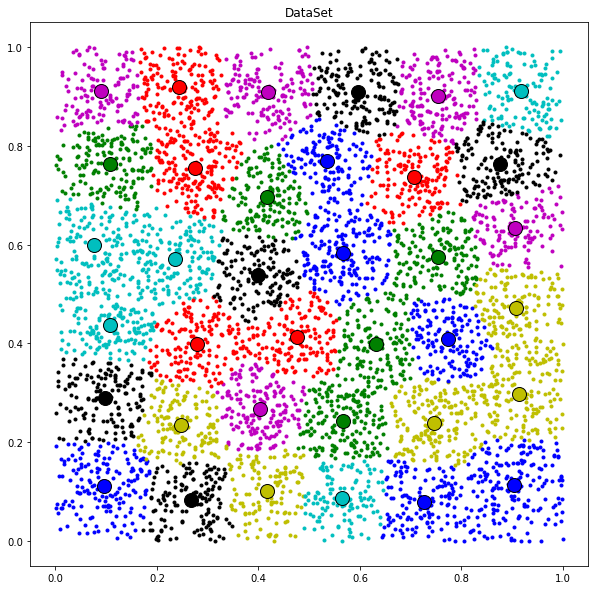

In [28]:
draw_dataset(samples, centroids, sample_membership)

# Center Shaking VNS

In [29]:
%%time

kmax = 10

local_max_iters = 300
local_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol, True)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.960358905527375
Iterations: 30
Clusters: 36

objective                     k      n_iters        n_iters_k      cpu_time       
23.527665                     2      1              0              0.05           
23.272862                     1      2              0              0.06           
23.236276                     1      3              0              0.07           
23.010185                     1      4              0              0.10           
23.009561                     1      15             1              0.28           
22.960517                     3      28             2              0.46           
22.960486                     4      32             2              0.49           
22.959370                     1      33             2              0.50           
22.957007                     1      44             3              0.63           
22.933017                     9      63             4              1.02           
22.932221                   

# Solution Visualization

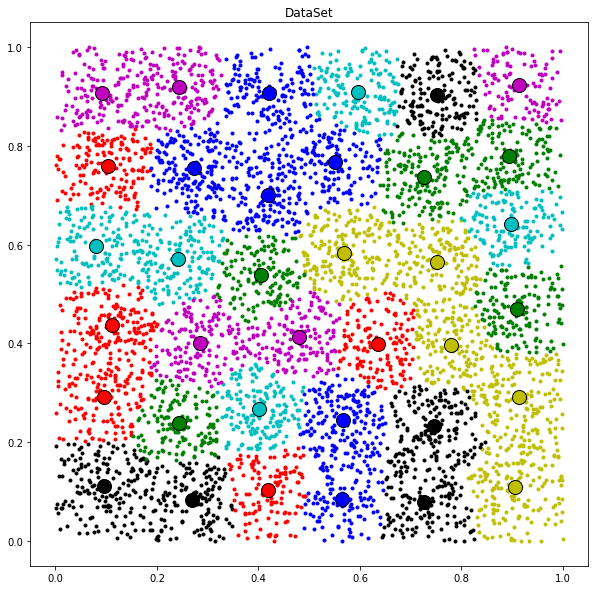

In [30]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [31]:
%%time

printing=True
local_max_iters=300
local_tol=0.0001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
23.874242606778548

Center Shaking VNS:
objective                     k      n_iters        n_iters_k      cpu_time       
23.843816                     1      0              0              0.03           
23.627753                     3      3              0              0.07           
23.103104                     1      4              0              0.10           
22.942484                     4      8              0              0.14           
22.939297                     2      35             5              0.44           
22.936894                     1      51             8              0.60           
22.936480                     1      77             13             0.92           
22.935922                     1      123            22             1.77           
22.935693                     3      126            22             1.79           
22.935491                     2      173            31             2.70           
22.935491                     5      1

# Solution Visualization

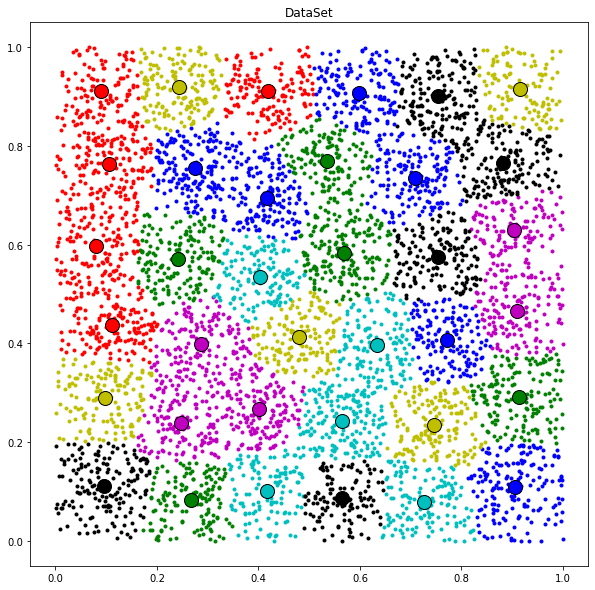

In [32]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [36]:
%%time

portion_size = 1000
n_portions = 5
init_method = 1
local_max_iters = 300
local_tol = 0.0001
max_cpu_time = 3
max_iters = 3000000
n_candidates = 6
aggregation_method = 1
basis_n_init = 3


method_sequence = np.array([0, 4, 5, 4, 5, 3])
kmax_sequence = np.array([0,5,5,5,15,0])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

# method_sequence = np.array([4])
# kmax_sequence = np.array([5])
# time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
# max_iters_sequence = np.full(method_sequence.shape[0],max_iters)


objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)



CPU times: user 2min 52s, sys: 39.7 s, total: 3min 32s
Wall time: 36.1 s


In [37]:
objective

22.927731416792376